# Import 套件 & Load Data

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
!wget -O data.csv https://raw.githubusercontent.com/edlin0317/taichung-house-price/main/B-B03-臺中市南區.csv

--2021-06-17 04:13:28--  https://raw.githubusercontent.com/edlin0317/taichung-house-price/main/B-B03-%E8%87%BA%E4%B8%AD%E5%B8%82%E5%8D%97%E5%8D%80.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.108.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5957462 (5.7M) [text/plain]
Saving to: ‘data.csv’

data.csv            100%[===================>]   5.68M  30.2MB/s    in 0.2s    

2021-06-17 04:13:29 (30.2 MB/s) - ‘data.csv’ saved [5957462/5957462]



# Data Pre-processing

## 轉換函數

In [2]:
def y_convert(t):
    t = str(t)
    year = int(t[:-2])
    return year

y_convert('11004')

def percentage_to_float(percent):
    if type(percent) == str:
        return int(percent.replace('.', '').replace('%',''))/10000
    return percent

percentage_to_float('18.88%')

def price_to_10k(price):
    return round(price/10000)

price_to_10k(157200)

def total_floor(f): #tf
    return f.split('/')[1]

def digit(c):
    pair = {
        '一':1, '二':2, '三':3, '四':4, '五':5, '六':6, '七':7, '八':7, '九':9, '十':10 
    }
    return pair[c]

def floor_to_int(f):
    f = f.replace('層', '')
    sum = 0
    if len(f) == 3:             #ex: 二十七
        sum+=digit(f[0])*10     #f[0] = 二
        sum+=digit(f[2])        #f[2] = 七
    if len(f) == 2:
        if not f[0] == '十':    #ex 二十
            sum+=digit(f[0])*10 #f[0] = 二
        else:                   #ex 十七
            sum+=10
            sum+=digit(f[1])
    if len(f) == 1:             #ex 七
        sum+=digit(f)           #f[0] = 七
    return sum

## 查看資料

In [3]:
df = pd.read_csv('data.csv')
#bs - 將字串轉float
df['bs'] = df['bs'].apply(percentage_to_float)
#將年月轉換成年
df['year'] = df['e'].apply(y_convert)
#將總價中的逗號移除
df['tp'] = df['tp'].str.replace(',','').astype(int)
#將每坪單價中的逗號移除
df['p'] = df['p'].str.replace(',','').astype(int)#.apply(price_to_10k)
#坪數 s 改為float
df['s'] = df['s'].str.replace(',','').astype(float)
#丟掉不相關欄位
df = df.drop(columns=['sq', 'AA12', 'cp', 'es', 'city', 'district_code', 'pimg', 'type', 'id'])
df.rename(columns={
    'a':'地址門牌(a)',
    'AA11':'用途(AA11)',
    'b':'建物類型(b)',
    'bs':'主建物占總面積比例(bs)',
    'e':'交易年月(e)',
    'el':'有無電梯(el)',
    'f':'交易樓層/總樓層(f)',
    'fi':'unknown(fi)',
    'g':'屋齡(g)',
    'j':'土地筆數(j)',
    'k':'建物筆數(k)',
    'l':'車位筆數(l)',
    'lat':'緯度(lat)',
    'lon':'經度(lon)',
    'm':'管委會(m)',
    'p':'每坪單價(p)',
    'r':'unknown(r)',
    's':'總坪數(s)',
    't':'類型(t)',
    'tp':'交易總價(tp)',
    'v':'格局(v)'
    }).head(10)

,用途(AA11),地址門牌(a),建物類型(b),主建物占總面積比例(bs),交易年月(e),有無電梯(el),交易樓層/總樓層(f),unknown(fi),屋齡(g),土地筆數(j),建物筆數(k),車位筆數(l),緯度(lat),經度(lon),管委會(m),每坪單價(p),unknown(r),總坪數(s),類型(t),交易總價(tp),格局(v),year
0,其他,南和路151~180號,住宅大樓(11層含以上有電梯),NaN,11003,有,九層/十五層,NaN,7.0,1,1,1,24.114653,120.667948,有,270916,61,49.83,房地(土地+建物)+車位,1350,3房2廳2衛有隔間,110
1,其他,學府路146巷1~30號,住宅大樓(11層含以上有電梯),0.5580,11003,有,十五層/二十一層,NaN,25.0,1,1,0,24.129161,120.674391,有,170631,50,11.14,房地(土地+建物),190,1房0廳1衛有隔間,110
2,其他,國光路365巷1~30號,華廈(10層含以下有電梯),0.7558,11003,有,"一層,騎樓,地下層/七層",NaN,29.0,3,1,0,24.120737,120.679649,有,153610,14,41.01,房地(土地+建物),630,NaN,110
3,其他,復興路三段1~30號,住宅大樓(11層含以上有電梯),0.9526,11003,有,八層/十三層,NaN,40.0,1,1,0,24.128173,120.667634,有,188688,17,5.30,房地(土地+建物),100,1房0廳1衛有隔間,110
4,其他,復興路一段271~300號,住宅大樓(11層含以上有電梯),0.6170,11003,有,六層/十三層,NaN,28.0,1,1,0,24.113345,120.652171,有,187031,58,10.69,房地(土地+建物),200,1房0廳1衛有隔間,110
5,其他,南平路91~120號,華廈(10層含以下有電梯),0.6642,11003,有,三層/八層,NaN,26.0,3,9,0,24.121690,120.664326,無,155808,23,866.46,房地(土地+建物),13500,16房13廳17衛有隔間,110
6,其他,信義南街91~120號,住宅大樓(11層含以上有電梯),0.6489,11003,有,十一層/二十四層,NaN,24.0,5,1,1,24.128219,120.673401,有,148479,61,44.11,房地(土地+建物)+車位,655,4房2廳2衛有隔間,110
7,其他,復興路二段205巷31~60號,透天厝,NaN,11003,有,全/五層,NaN,3.0,1,1,0,24.127548,120.665881,無,50714,11,121.31,房地(土地+建物),615,6房2廳5衛有隔間,110
8,其他,三民西路211~240號,住宅大樓(11層含以上有電梯),0.6148,11003,有,四層/十四層,NaN,20.0,2,1,1,24.130380,120.660720,有,214436,31,34.21,房地(土地+建物)+車位,750,3房2廳2衛有隔間,110
9,其他,高工路91~120號,華廈(10層含以下有電梯),0.6856,11003,有,六層/八層,NaN,26.0,1,1,0,24.113422,120.658645,有,144701,35,38.01,房地(土地+建物),550,3房2廳2衛有隔間,110


## 觀察建物類型

In [4]:
#查看類型分布
pd.DataFrame(df['b'].value_counts(dropna=False))

,b
住宅大樓(11層含以上有電梯),14109
透天厝,1960
華廈(10層含以下有電梯),1384
公寓(5樓含以下無電梯),1052
套房(1房(1廳)1衛),828
店面（店舖),464
辦公商業大樓,136
其他,30
廠辦,14
工廠,9


## 只保留「住宅大樓」 其他類型樣本數不足 - 剔除

In [5]:
# 只保留「住宅大樓」 其他類型樣本數不足 - 剔除
#df = df.drop(df.loc[(df['b'] == '住宅大樓(11層含以上有電梯)')].index)
df = df.drop(df.loc[(df['b'] == '透天厝')].index)
df = df.drop(df.loc[(df['b'] == '華廈(10層含以下有電梯)')].index)
df = df.drop(df.loc[(df['b'] == '公寓(5樓含以下無電梯)')].index)
df = df.drop(df.loc[(df['b'] == '套房(1房(1廳)1衛)')].index)
df = df.drop(df.loc[(df['b'] == '店面（店舖)')].index)
df = df.drop(df.loc[(df['b'] == '辦公商業大樓')].index)
df = df.drop(df.loc[(df['b'] == '其他')].index)
df = df.drop(df.loc[(df['b'] == '廠辦')].index)
df = df.drop(df.loc[(df['b'] == '工廠')].index)
df = df.drop(df.loc[(df['b'] == '倉庫')].index)
df

,AA11,a,b,bs,e,el,f,fi,g,j,k,l,lat,lon,m,p,r,s,t,tp,v,year
0,其他,南和路151~180號,住宅大樓(11層含以上有電梯),NaN,11003,有,九層/十五層,NaN,7.0,1,1,1,24.114653,120.667948,有,270916,61,49.83,房地(土地+建物)+車位,1350,3房2廳2衛有隔間,110
1,其他,學府路146巷1~30號,住宅大樓(11層含以上有電梯),0.5580,11003,有,十五層/二十一層,NaN,25.0,1,1,0,24.129161,120.674391,有,170631,50,11.14,房地(土地+建物),190,1房0廳1衛有隔間,110
3,其他,復興路三段1~30號,住宅大樓(11層含以上有電梯),0.9526,11003,有,八層/十三層,NaN,40.0,1,1,0,24.128173,120.667634,有,188688,17,5.30,房地(土地+建物),100,1房0廳1衛有隔間,110
4,其他,復興路一段271~300號,住宅大樓(11層含以上有電梯),0.6170,11003,有,六層/十三層,NaN,28.0,1,1,0,24.113345,120.652171,有,187031,58,10.69,房地(土地+建物),200,1房0廳1衛有隔間,110
6,其他,信義南街91~120號,住宅大樓(11層含以上有電梯),0.6489,11003,有,十一層/二十四層,NaN,24.0,5,1,1,24.128219,120.673401,有,148479,61,44.11,房地(土地+建物)+車位,655,4房2廳2衛有隔間,110
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19958,住,樹德里文心南路541~570號,住宅大樓(11層含以上有電梯),0.4893,10003,無,五層/十五層,1.0,2.0,1,1,1,24.119859,120.651469,有,127630,70,52.90,房地(土地+建物)+車位,644,3房2廳2衛有隔間,100
19959,住,樹德里文心南路541~570號,住宅大樓(11層含以上有電梯),0.4819,10003,無,五層/十五層,1.0,2.0,1,1,1,24.119859,120.651469,有,143332,70,46.43,房地(土地+建物)+車位,610,2房2廳2衛有隔間,100
19960,住,樹德里文心南路541~570號,住宅大樓(11層含以上有電梯),0.4939,10003,無,十層/十五層,1.0,2.0,1,1,1,24.119859,120.651469,有,141398,70,57.19,房地(土地+建物)+車位,770,3房2廳2衛有隔間,100
19961,住,樹德里文心南路541~570號,住宅大樓(11層含以上有電梯),0.4819,10003,無,八層/十五層,1.0,2.0,1,1,1,24.119859,120.651469,有,143332,70,46.43,房地(土地+建物)+車位,620,2房2廳2衛有隔間,100


## 只保留AA11「住」

In [6]:
#查看類型分布
pd.DataFrame(df['AA11'].value_counts(dropna=False))

,AA11
住,10857
其他,1745
商,1412
NaN,91
工,2
住宅區,2


In [7]:
#只保留非NaN
df = df[df['AA11'].notna()]
#只保留「住」
df = df.drop(df.loc[(df['AA11'] == '其他')].index)
df = df.drop(df.loc[(df['AA11'] == '商')].index)
df = df.drop(df.loc[(df['AA11'] == '工')].index)
df = df.drop(df.loc[(df['AA11'] == '住宅區')].index)
df = df.drop(df.loc[(df['AA11'] == '農')].index)
df = df.drop(df.loc[(df['AA11'] == '山坡地保育區')].index)
df = df.drop(df.loc[(df['AA11'] == '特定農業區')].index)
df = df.drop(df.loc[(df['AA11'] == '鄉村區')].index)
#處理結果
pd.DataFrame(df['AA11'].value_counts(dropna=False))

,AA11
住,10857


## 只取 101 年

In [8]:
df_101 = df.loc[(df['year'] == 101)]
df_101

,AA11,a,b,bs,e,el,f,fi,g,j,k,l,lat,lon,m,p,r,s,t,tp,v,year
18216,住,南和路151~180號,住宅大樓(11層含以上有電梯),0.6727,10112,無,十六層/二十二層,-1.0,18.0,1,1,0,24.115926,120.668072,有,129974,63,35.78,房地(土地+建物),465,4房0廳4衛有隔間,101
18221,住,南和路181~210號,住宅大樓(11層含以上有電梯),0.6200,10112,無,五層/十六層,-1.0,20.0,1,2,0,24.117554,120.667888,無,102883,64,44.23,房地(土地+建物)+車位,455,3房2廳2衛有隔間,101
18222,住,文心南十路211~240號,住宅大樓(11層含以上有電梯),0.5927,10112,無,十七層/三十二層,-1.0,6.0,1,2,0,24.118528,120.658202,有,114883,58,39.17,房地(土地+建物),450,3房1廳2衛有隔間,101
18223,住,忠明南路571~600號,住宅大樓(11層含以上有電梯),0.6133,10112,無,二層/十四層,-1.0,8.0,1,1,0,24.130560,120.657258,有,162628,59,20.29,房地(土地+建物),330,1房1廳1衛有隔間,101
18225,住,五權南一路31~60號,住宅大樓(11層含以上有電梯),0.5213,10112,無,九層/十五層,-1.0,1.0,1,1,1,24.113078,120.670066,有,136909,71,45.65,房地(土地+建物)+車位,625,3房2廳2衛有隔間,101
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19817,住,忠明南路931~960號,住宅大樓(11層含以上有電梯),0.4934,10101,無,九層/十五層,1.0,2.0,1,1,1,24.118478,120.663898,有,148046,52,57.64,房地(土地+建物)+車位,830,3房2廳2衛有隔間,101
19818,住,忠明南路931~960號,住宅大樓(11層含以上有電梯),0.4934,10101,無,十三層/十五層,1.0,2.0,1,1,1,24.118478,120.663898,有,156274,52,57.64,房地(土地+建物)+車位,860,3房2廳2衛有隔間,101
19819,住,樹德里文心南路541~570號,住宅大樓(11層含以上有電梯),0.4486,10101,無,七層/十五層,1.0,2.0,1,1,2,24.119859,120.651469,有,155633,70,75.07,房地(土地+建物)+車位,1055,4房2廳2衛有隔間,101
19820,住,忠明南路931~960號,住宅大樓(11層含以上有電梯),0.5013,10101,無,七層/十五層,1.0,2.0,1,1,1,24.118785,120.663730,有,152850,52,65.79,房地(土地+建物)+車位,968,4房2廳2衛有隔間,101


In [9]:
df_101.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1047 entries, 18216 to 19821
Data columns (total 22 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   AA11    1047 non-null   object 
 1   a       1047 non-null   object 
 2   b       1047 non-null   object 
 3   bs      922 non-null    float64
 4   e       1047 non-null   int64  
 5   el      1047 non-null   object 
 6   f       1046 non-null   object 
 7   fi      1047 non-null   float64
 8   g       742 non-null    float64
 9   j       1047 non-null   int64  
 10  k       1047 non-null   int64  
 11  l       1047 non-null   int64  
 12  lat     1047 non-null   float64
 13  lon     1047 non-null   float64
 14  m       1047 non-null   object 
 15  p       1047 non-null   int64  
 16  r       1047 non-null   int64  
 17  s       1047 non-null   float64
 18  t       1047 non-null   object 
 19  tp      1047 non-null   int64  
 20  v       1032 non-null   object 
 21  year    1047 non-null   int64  


## 查看資料分布

In [10]:
#清除格局空值
df_101 = df_101[df_101['v'].notna()]
df_101

,AA11,a,b,bs,e,el,f,fi,g,j,k,l,lat,lon,m,p,r,s,t,tp,v,year
18216,住,南和路151~180號,住宅大樓(11層含以上有電梯),0.6727,10112,無,十六層/二十二層,-1.0,18.0,1,1,0,24.115926,120.668072,有,129974,63,35.78,房地(土地+建物),465,4房0廳4衛有隔間,101
18221,住,南和路181~210號,住宅大樓(11層含以上有電梯),0.6200,10112,無,五層/十六層,-1.0,20.0,1,2,0,24.117554,120.667888,無,102883,64,44.23,房地(土地+建物)+車位,455,3房2廳2衛有隔間,101
18222,住,文心南十路211~240號,住宅大樓(11層含以上有電梯),0.5927,10112,無,十七層/三十二層,-1.0,6.0,1,2,0,24.118528,120.658202,有,114883,58,39.17,房地(土地+建物),450,3房1廳2衛有隔間,101
18223,住,忠明南路571~600號,住宅大樓(11層含以上有電梯),0.6133,10112,無,二層/十四層,-1.0,8.0,1,1,0,24.130560,120.657258,有,162628,59,20.29,房地(土地+建物),330,1房1廳1衛有隔間,101
18225,住,五權南一路31~60號,住宅大樓(11層含以上有電梯),0.5213,10112,無,九層/十五層,-1.0,1.0,1,1,1,24.113078,120.670066,有,136909,71,45.65,房地(土地+建物)+車位,625,3房2廳2衛有隔間,101
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19817,住,忠明南路931~960號,住宅大樓(11層含以上有電梯),0.4934,10101,無,九層/十五層,1.0,2.0,1,1,1,24.118478,120.663898,有,148046,52,57.64,房地(土地+建物)+車位,830,3房2廳2衛有隔間,101
19818,住,忠明南路931~960號,住宅大樓(11層含以上有電梯),0.4934,10101,無,十三層/十五層,1.0,2.0,1,1,1,24.118478,120.663898,有,156274,52,57.64,房地(土地+建物)+車位,860,3房2廳2衛有隔間,101
19819,住,樹德里文心南路541~570號,住宅大樓(11層含以上有電梯),0.4486,10101,無,七層/十五層,1.0,2.0,1,1,2,24.119859,120.651469,有,155633,70,75.07,房地(土地+建物)+車位,1055,4房2廳2衛有隔間,101
19820,住,忠明南路931~960號,住宅大樓(11層含以上有電梯),0.5013,10101,無,七層/十五層,1.0,2.0,1,1,1,24.118785,120.663730,有,152850,52,65.79,房地(土地+建物)+車位,968,4房2廳2衛有隔間,101


In [11]:
#查看格局分布
pd.DataFrame(df_101['v'].value_counts(dropna=False)).head(10)

,v
3房2廳2衛有隔間,618
4房2廳2衛有隔間,140
2房2廳1衛有隔間,104
2房2廳2衛有隔間,50
1房1廳1衛有隔間,21
2房1廳1衛有隔間,19
3房1廳2衛有隔間,15
3房2廳1衛有隔間,8
3房2廳3衛有隔間,7
1房0廳1衛有隔間,7


In [12]:
def room(v):
    return int(v.split('房')[0])

def living(v):
    return int(v.split('房')[1].split('廳')[0])

def toilet(v):
    return int(v.split('廳')[1].split('衛')[0])

In [13]:
#房數 room
df_101['room'] = df_101['v'].apply(room)
#廳數 living
df_101['living'] = df_101['v'].apply(living)
#衛數 toilet
df_101['toilet'] = df_101['v'].apply(toilet)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: ht

In [14]:
#查看 room 分布
pd.DataFrame(df_101['room'].value_counts(dropna=False)).head(10)

,room
3,658
2,182
4,146
1,30
5,11
0,5


In [15]:
#查看 living 分布
pd.DataFrame(df_101['living'].value_counts(dropna=False)).head(10)

,living
2,938
1,65
0,24
3,5


In [16]:
#查看 toilet 分布
pd.DataFrame(df_101['toilet'].value_counts(dropna=False)).head(10)

,toilet
2,838
1,170
3,16
5,5
4,3


In [17]:
df_101.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1032 entries, 18216 to 19821
Data columns (total 25 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   AA11    1032 non-null   object 
 1   a       1032 non-null   object 
 2   b       1032 non-null   object 
 3   bs      911 non-null    float64
 4   e       1032 non-null   int64  
 5   el      1032 non-null   object 
 6   f       1032 non-null   object 
 7   fi      1032 non-null   float64
 8   g       730 non-null    float64
 9   j       1032 non-null   int64  
 10  k       1032 non-null   int64  
 11  l       1032 non-null   int64  
 12  lat     1032 non-null   float64
 13  lon     1032 non-null   float64
 14  m       1032 non-null   object 
 15  p       1032 non-null   int64  
 16  r       1032 non-null   int64  
 17  s       1032 non-null   float64
 18  t       1032 non-null   object 
 19  tp      1032 non-null   int64  
 20  v       1032 non-null   object 
 21  year    1032 non-null   int64  


In [18]:
s_lower = df_101.s.quantile(0.05)
s_median = df_101.s.quantile(0.5)
s_upper = df_101.s.quantile(0.95)
print(s_lower, s_median, s_upper)

p_lower = df_101.p.quantile(0.05)
p_median = df_101.p.quantile(0.5)
p_upper = df_101.p.quantile(0.95)
print(p_lower, p_median, p_upper)

tp_lower = df_101['tp'].quantile(0.05)
tp_median = df_101['tp'].quantile(0.5)
tp_upper = df_101['tp'].quantile(0.95)
print(tp_lower, tp_median, tp_upper)

23.616500000000002 47.78 73.70349999999999
82213.2 119742.0 183848.75
260.0 500.0 1130.0


In [19]:
#剔除極值 - 捨去坪數 s 太大/太小
df_101 = df_101.drop(df_101.loc[(df_101['s'] < s_lower) & True].index)
df_101 = df_101.drop(df_101.loc[df_101['s'] > s_upper].index)
print(len(df_101))
#剔除極值 - 捨去每坪單價 p 太大/太小
df_101 = df_101.drop(df_101.loc[df_101['p'] < p_lower].index)
df_101 = df_101.drop(df_101.loc[df_101['p'] > p_upper].index)
print(len(df_101))
#剔除極值 - 捨去總價 tp 太大/太小
df_101 = df_101.drop(df_101.loc[df_101['tp'] < tp_lower].index)
df_101 = df_101.drop(df_101.loc[df_101['tp'] > tp_upper].index)
print(len(df_101))

928
844
818


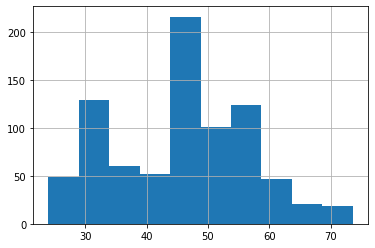

In [20]:
df_101.s.hist()

In [40]:
df_101.s.describe()

count    818.000000
mean      45.859817
std       11.114084
min       24.020000
25%       36.220000
50%       47.780000
75%       53.820000
max       73.600000
Name: s, dtype: float64

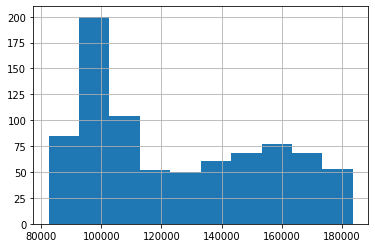

In [21]:
df_101.p.hist()

In [22]:
df_101.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 818 entries, 18216 to 19821
Data columns (total 25 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   AA11    818 non-null    object 
 1   a       818 non-null    object 
 2   b       818 non-null    object 
 3   bs      714 non-null    float64
 4   e       818 non-null    int64  
 5   el      818 non-null    object 
 6   f       818 non-null    object 
 7   fi      818 non-null    float64
 8   g       546 non-null    float64
 9   j       818 non-null    int64  
 10  k       818 non-null    int64  
 11  l       818 non-null    int64  
 12  lat     818 non-null    float64
 13  lon     818 non-null    float64
 14  m       818 non-null    object 
 15  p       818 non-null    int64  
 16  r       818 non-null    int64  
 17  s       818 non-null    float64
 18  t       818 non-null    object 
 19  tp      818 non-null    int64  
 20  v       818 non-null    object 
 21  year    818 non-null    int64  
 

In [23]:
#補缺值
df_101['bs'] = df_101['bs'].fillna(1) #假設主建物比=1
df_101['g'] = df_101['g'].fillna(0) #假設屋齡=0

In [24]:
df_101['real_s'] = df_101['bs'] * df_101['s']

In [25]:
tmp = df_101[['bs','g','l','lat','lon','s','room','living','toilet', 'real_s','tp','p']]
tmp

,bs,g,l,lat,lon,s,room,living,toilet,real_s,tp,p
18216,0.6727,18.0,0,24.115926,120.668072,35.78,4,0,4,24.069206,465,129974
18221,0.6200,20.0,0,24.117554,120.667888,44.23,3,2,2,27.422600,455,102883
18222,0.5927,6.0,0,24.118528,120.658202,39.17,3,1,2,23.216059,450,114883
18225,0.5213,1.0,1,24.113078,120.670066,45.65,3,2,2,23.797345,625,136909
18227,0.6101,11.0,1,24.123997,120.671051,59.84,4,2,2,36.508384,960,160420
...,...,...,...,...,...,...,...,...,...,...,...,...
19816,0.4934,2.0,1,24.118478,120.663898,57.64,3,2,2,28.439576,790,141878
19817,0.4934,2.0,1,24.118478,120.663898,57.64,3,2,2,28.439576,830,148046
19818,0.4934,2.0,1,24.118478,120.663898,57.64,3,2,2,28.439576,860,156274
19820,0.5013,2.0,1,24.118785,120.663730,65.79,4,2,2,32.980527,968,152850


In [26]:
tmp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 818 entries, 18216 to 19821
Data columns (total 12 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   bs      818 non-null    float64
 1   g       818 non-null    float64
 2   l       818 non-null    int64  
 3   lat     818 non-null    float64
 4   lon     818 non-null    float64
 5   s       818 non-null    float64
 6   room    818 non-null    int64  
 7   living  818 non-null    int64  
 8   toilet  818 non-null    int64  
 9   real_s  818 non-null    float64
 10  tp      818 non-null    int64  
 11  p       818 non-null    int64  
dtypes: float64(6), int64(6)
memory usage: 83.1 KB


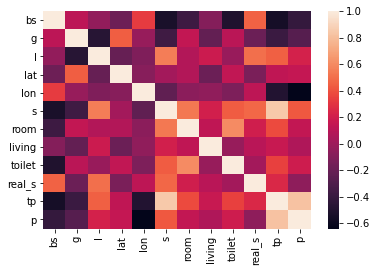

In [27]:
corr = tmp.corr()

sns.heatmap(corr, 
        xticklabels=corr.columns,
        yticklabels=corr.columns)

# 預測

In [28]:
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
import xgboost as xgb
from sklearn.model_selection import train_test_split



# for n_neighbors in range(50,100):
#     print(n_neighbors)

best_score = 0
best_model = None

#預測總價
# X = tmp.drop(columns=['tp','p']).values
# y = tmp['tp'].values
#預測單價
X = tmp.drop(columns=['tp','p']).values
y = tmp['p'].values

for i in range(100):
    X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.2)
    #model = linear_model.LinearRegression()
    #model = KNeighborsRegressor(n_neighbors=3)
    #model = DecisionTreeRegressor()
    model = xgb.XGBRegressor(verbosity = 0) #suppress warning
    model.fit(X_train, Y_train)
    Y_pred = model.predict(X_test)
    score = round(r2_score(Y_test, Y_pred),2)
    #print(score)
    if score > best_score:
        best_model = model
        best_score = score

print(f'test samples:{len(X_test)}')
print(f'best score: {best_score}')

test samples:164
best score: 0.89


In [29]:
compare = pd.DataFrame({'Y_pred(預測)':Y_pred, 'Y_test(實際)':Y_test, 'diff':(Y_pred-Y_test)/Y_test, 'abs_diff':abs((Y_pred-Y_test)/Y_test)})
compare['diff'] = compare['diff'].round(2)
compare['abs_diff'] = compare['abs_diff'].round(2)
compare.head(15)

,Y_pred(預測),Y_test(實際),diff,abs_diff
0,104038.250000,109223,-0.05,0.05
1,94601.062500,85633,0.10,0.10
2,103472.375000,107425,-0.04,0.04
3,98941.406250,90909,0.09,0.09
4,104609.195312,103650,0.01,0.01
5,102961.312500,114407,-0.10,0.10
6,148280.968750,176255,-0.16,0.16
7,122462.531250,118466,0.03,0.03
8,161660.265625,153564,0.05,0.05
9,101005.562500,91203,0.11,0.11


In [30]:
print(compare['diff'].quantile(0.1))
print(compare['diff'].quantile(0.9))
compare.describe()

-0.097
0.10999999999999999


,Y_pred(預測),Y_test(實際),diff,abs_diff
count,164.000000,164.000000,164.000000,164.000000
mean,121560.867188,122138.207317,0.006098,0.068415
std,26648.125000,29985.543809,0.098613,0.071082
min,93428.312500,82403.000000,-0.410000,0.000000
25%,98941.406250,98521.250000,-0.040000,0.020000
50%,106434.113281,109686.000000,0.010000,0.050000
75%,149023.453125,149577.250000,0.060000,0.090000
max,175779.234375,183752.000000,0.320000,0.410000


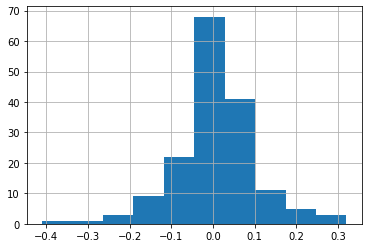

In [31]:
compare['diff'].hist(bins=10)

In [32]:
compare['diff'].value_counts(normalize=True)

 0.00    0.097561
-0.04    0.073171
 0.01    0.073171
 0.02    0.067073
 0.06    0.054878
 0.03    0.048780
-0.02    0.042683
-0.05    0.042683
 0.05    0.036585
-0.03    0.036585
-0.06    0.036585
 0.09    0.030488
-0.01    0.024390
 0.08    0.024390
 0.04    0.024390
-0.07    0.018293
-0.09    0.018293
 0.11    0.018293
 0.12    0.018293
 0.10    0.018293
 0.07    0.012195
-0.10    0.012195
-0.13    0.012195
 0.18    0.012195
 0.14    0.012195
 0.16    0.006098
 0.25    0.006098
 0.24    0.006098
-0.14    0.006098
 0.23    0.006098
 0.17    0.006098
-0.11    0.006098
 0.32    0.006098
-0.41    0.006098
-0.17    0.006098
 0.27    0.006098
-0.26    0.006098
-0.15    0.006098
-0.30    0.006098
 0.15    0.006098
 0.20    0.006098
-0.23    0.006098
-0.19    0.006098
-0.18    0.006098
-0.12    0.006098
-0.20    0.006098
-0.16    0.006098
Name: diff, dtype: float64

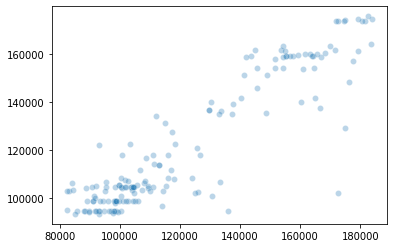

In [33]:
import seaborn as sns
sns.scatterplot(x=Y_test, y=Y_pred, alpha=0.3)

In [34]:
tmp

,bs,g,l,lat,lon,s,room,living,toilet,real_s,tp,p
18216,0.6727,18.0,0,24.115926,120.668072,35.78,4,0,4,24.069206,465,129974
18221,0.6200,20.0,0,24.117554,120.667888,44.23,3,2,2,27.422600,455,102883
18222,0.5927,6.0,0,24.118528,120.658202,39.17,3,1,2,23.216059,450,114883
18225,0.5213,1.0,1,24.113078,120.670066,45.65,3,2,2,23.797345,625,136909
18227,0.6101,11.0,1,24.123997,120.671051,59.84,4,2,2,36.508384,960,160420
...,...,...,...,...,...,...,...,...,...,...,...,...
19816,0.4934,2.0,1,24.118478,120.663898,57.64,3,2,2,28.439576,790,141878
19817,0.4934,2.0,1,24.118478,120.663898,57.64,3,2,2,28.439576,830,148046
19818,0.4934,2.0,1,24.118478,120.663898,57.64,3,2,2,28.439576,860,156274
19820,0.5013,2.0,1,24.118785,120.663730,65.79,4,2,2,32.980527,968,152850


In [35]:
# pd.DataFrame(tmp.loc[43005]).transpose()

In [36]:
# #data = [float(item) for item in '0.6727	18.0	0.0	24.115926	120.668072	35.78	4.0	0.0	4.0	24.069206'.split('\t')]
# #new_data = [data]
# new_data = [tmp.drop(columns=['tp','p']).loc[39398].values]
# result = model.predict(new_data)[0]
# print(result)

#test api

In [41]:
import requests

In [47]:
#GET Method
url = 'https://7b688884fa0e.ngrok.io/model_api?city=B&district=B07&year=108&lat=24.124566887961176&lon=120.67507110914983&bs=0.6&g=0&l=1&room=2&living=1&toilet=1&s=50&real_s=30'
r = requests.get(url)
r.text

'{"p":306097,"tp":1435}\n'

In [46]:
# #POST Method
# url = 'https://7b688884fa0e.ngrok.io/model_api'
# city='B'
# district='B07'
# year=108
# lat=24.124566887961176
# lon=120.67507110914983
# bs=0.6
# g=0
# l=1
# room=2
# living=1
# toilet=1
# s=50
# real_s=30
# data = {
#     'city':city,
#     'district':district,
#     'year':year,
#     'bs':bs,#主建物比
#     'g':g,#屋齡
#     'l':l,#車位數
#     'lat':lat,#緯度
#     'lon':lon,#經度
#     's':s,#總坪數
#     'room':room,#房
#     'living':living,#廳
#     'toilet':toilet,#衛
#     'real_s':real_s#主建物坪數
# }
# r = requests.get(url=url, data=data)
# r.text

"'in <string>' requires string as left operand, not NoneType"